### Data Preprocessing:
1. The code begins by importing necessary libraries such as pandas, numpy, matplotlib, seaborn, and various regression models from scikit-learn.
2. It reads a CSV file named "train_data.csv" into a pandas DataFrame `ds_copy`.
3. Missing values are checked and found to be absent in the dataset.
4. Three categorical variables ('sex', 'smoker', 'region') are integer-encoded using dictionaries.
5. The dataset is then saved back to the CSV file.

### Exploratory Data Analysis (EDA):
Statistical data visualization is performed using seaborn's heatmap to visualize the correlation matrix of the features in the dataset.

### Outlier Detection:
1. The code defines a function `diagnostic_plots` to create histograms, Q-Q plots, and boxplots for visualizing potential outliers.
2. Outlier detection is performed for variables 'age', 'bmi', and 'charges' using the `diagnostic_plots` function.

### Model Building:
1. The dataset is split into features (`X`) and target (`y`) variables.
2. Several regression models (Linear Regression, Ridge Regression, Lasso Regression, K-Nearest Neighbors, Random Forest, XGBoost, Decision Tree, Gradient Boosting, and Extra Trees) are instantiated.
3. Each model is trained on the training data, and its performance metrics such as R-squared, RMSE, and MAE are calculated on both training and testing datasets.
4. The results are stored in a DataFrame and saved to a CSV file.
5. The best performing models (Random Forest and XGBoost) are saved using pickle.

### Variable Importance. The feature importances of the best model (Gradient Boosting Regressor) are plotted and saved to a PNG file.

### Model Evaluation with Best Hyperparameters:
1. The best hyperparameters for the Gradient Boosting Regressor are loaded from a separate file.
2. The model is instantiated with these hyperparameters and trained on the entire dataset.
3. Performance metrics (Score, MSE, MAE, R2) are calculated on the training data.
4. The metrics are saved to a CSV file.

### Final Model. The finalized model (Gradient Boosting Regressor) is saved using pickle.

### Conclusion:
This code performs end-to-end tasks for predicting personal medical insurance costs, including data preprocessing, exploratory data analysis, model building, evaluation, and finalization. Additionally, it saves important results and models for future use.

## Data Preprocessing: missing values detection, feature encoding & corelation matrix

In [1]:
import pickle

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
# statistical data visualization
import seaborn as sns

In [4]:
from sklearn.model_selection import ShuffleSplit

In [5]:
# scale numerical features to a specified range
from sklearn.preprocessing import MinMaxScaler

In [6]:
# custom files
import columns

In [7]:
dataset_path = "D:/programming/information-technologies-of-smart-systems/term-paper/data/final/train_data.csv"

In [8]:
ds_copy = pd.read_csv(dataset_path)

In [10]:
# no missing value
ds_copy.isnull().sum()

Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [ ]:
# dropping the useless column 'Unnamed: 0'
ds_copy = ds_copy.drop('Unnamed: 0', axis=1)

# dropping the useless column 'flight'
ds_copy = ds_copy.drop('flight', axis=1)

# rename 'class' name to 'flight_class', because *class* is python reserved name
ds_copy.rename(columns={'class': 'flight_class'}, inplace=True)

In [12]:
param_dict_path = "D:/programming/information-technologies-of-smart-systems/term-paper/src/param_dict.pickle"

In [13]:
# load parameter dictionary
try:
    with open(param_dict_path, 'rb') as f:
        param_dict = pickle.load(f)
except FileNotFoundError:
    print("Error: Parameter dictionary file not found!")
    exit()

In [16]:
ds_copy.head(5)

,airline,source_city,departure_time,stops,arrival_time,destination_city,flight_class,duration,days_left,price
0,Vistara,Mumbai,Early_Morning,one,Night,Delhi,Business,13.50,19,53152
1,Air_India,Kolkata,Afternoon,one,Morning,Hyderabad,Economy,20.42,23,6090
2,Air_India,Bangalore,Afternoon,one,Evening,Mumbai,Business,29.00,6,44863
3,Vistara,Bangalore,Early_Morning,one,Night,Hyderabad,Business,14.92,28,56588
4,Air_India,Mumbai,Night,one,Night,Hyderabad,Economy,26.08,16,4593


In [17]:
# categorical encoding
for column in columns.cat_columns[0:]:
    ds_copy[column] = ds_copy[column].map(param_dict['map_dicts'][column])

In [18]:
ds_copy.head(5)

,airline,source_city,departure_time,stops,arrival_time,destination_city,flight_class,duration,days_left,price
0,5,5,1,1,5,2,0,13.50,19,53152
1,1,4,0,1,4,3,1,20.42,23,6090
2,1,0,0,1,2,5,0,29.00,6,44863
3,5,0,1,1,5,3,0,14.92,28,56588
4,1,5,5,1,5,3,1,26.08,16,4593


In [20]:
ds_copy.to_csv(dataset_path, index=False)

In [21]:
# statistical data visualization
import seaborn as sns

# creating static, animated, and interactive visualizations
import matplotlib.pyplot as plt

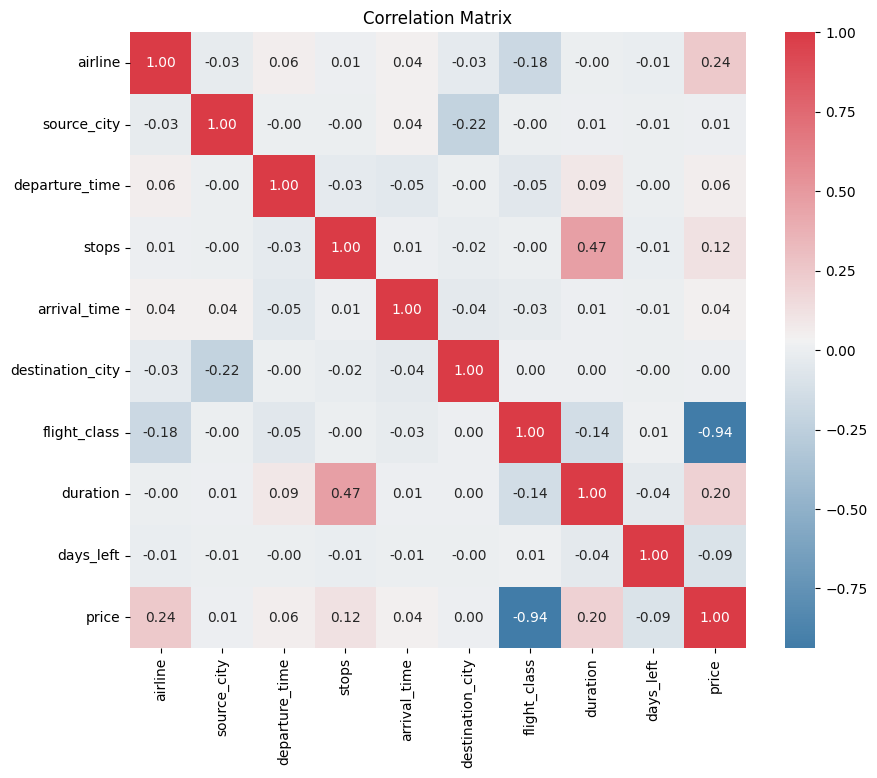

In [22]:
# create a subplot with specified figure size
f, ax = plt.subplots(figsize=(10, 8))

corr = ds_copy.corr()

# Create a heatmap of the correlation matrix
# Set the mask to hide the upper triangle of the heatmap
# Set the color map using seaborn's diverging_palette
# Add annotations to display correlation values in each cell
# Format annotations to two decimal places
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax, annot=True, fmt=".2f")

ax.set_title('Correlation Matrix')
plt.show()

## Outlier Engineering

1. **diagnostic_plots Function**: This function takes a dataframe `df` and a variable name `variable` as input. It generates three diagnostic plots for the specified variable: Histogram, Q-Q plot (Quantile-Quantile plot), and Boxplot.
2. **Histogram**: Shows the distribution of the variable.
3. **Q-Q Plot**: Compares the distribution of the variable against a normal distribution. If the data points fall approximately along the diagonal line, the variable is normally distributed.
4. **Boxplot**: Provides a visual summary of the central tendency, dispersion, and skewness of the data, and identifies potential outliers.
5. **Outlier Detection**: The function `diagnostic_plots` is called three times to generate diagnostic plots for the variables 'age', 'bmi', and 'charges', allowing us to visually identify outliers in the dataset.

In [14]:
from scipy import stats

In [23]:
# function to create histogram, Q-Q plot and
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30, color='lightgreen')
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')
    plt.gca().get_lines()[0].set_color('blue')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable], color='darkorange')
    plt.title('Boxplot')

    plt.show()

In [24]:
ds_copy.nunique()

airline                 6
source_city             6
departure_time          6
stops                   3
arrival_time            6
destination_city        6
flight_class            2
duration              468
days_left              49
price               11012
dtype: int64

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


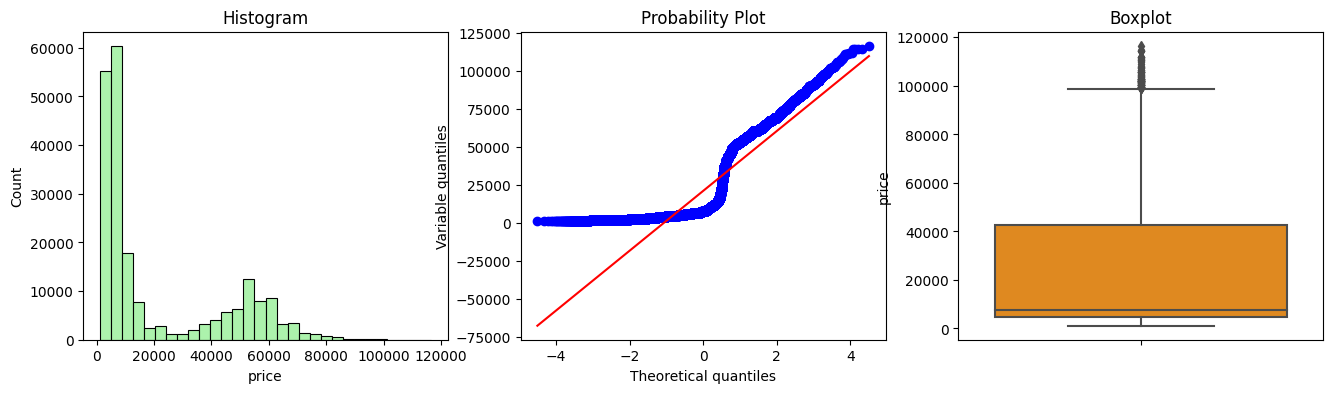

In [25]:
# let's find outliers in feature 'price'
diagnostic_plots(ds_copy, 'price')

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


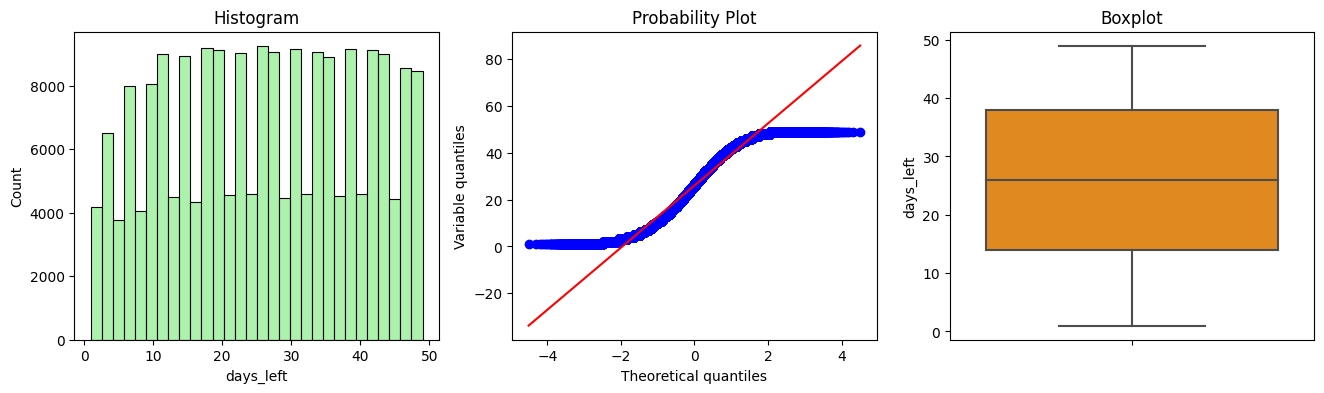

In [26]:
# let's find outliers in feature 'days_left'
diagnostic_plots(ds_copy, 'days_left')

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


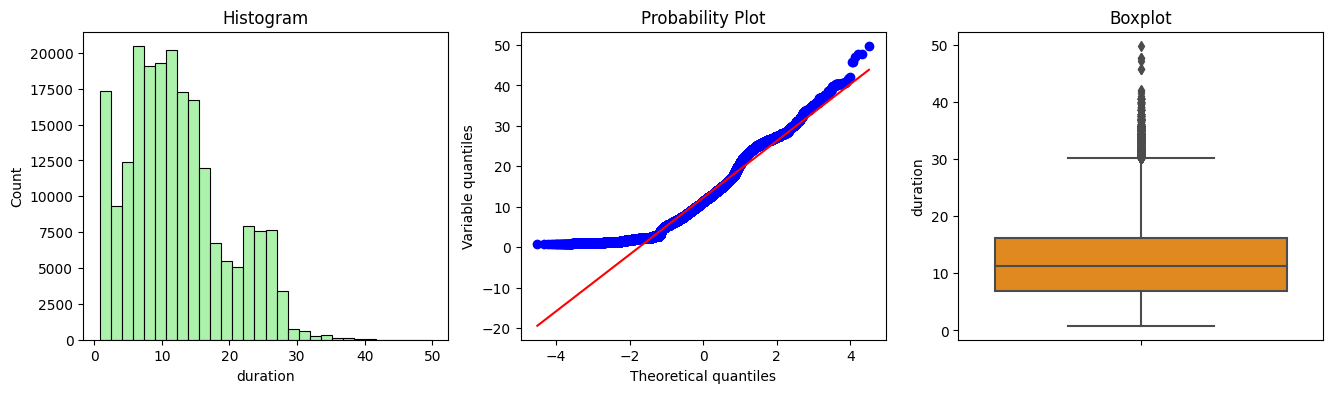

In [27]:
# let's find outliers in feature 'duration'
diagnostic_plots(ds_copy, 'duration')

## Normalization

Normalization is a data preprocessing technique used to scale the features of a dataset to a specific range, typically 0 to 1. This process ensures that all features contribute equally to the analysis and prevents any single feature from dominating due to its scale.



1. **Initialize the Scaler**.
Create an instance of `MinMaxScaler` to scale the features.

2. **Fit the Scaler to the Train Set**
   - Select the columns from the dataset that need to be scaled.
   - `X_tmp = ds_copy[columns.X_columns]` stores the selected columns in a temporary DataFrame.

3. **Transform Train and Test Sets**
    - Fit the scaler to the training data and transform it, learning the parameters (minimum and maximum values for each feature).
    - `scaler = MinMaxScaler().fit_transform(X_tmp)` performs the fitting and transformation.

4. **Store Column Names**
    - Extract and store the column names from `X_tmp` to ensure the transformed data has the correct labels.
    - `columns_to_replace = X_tmp.columns` saves the column names.

5. **Convert to DataFrame**
    - Convert the transformed NumPy array back into a DataFrame, retaining the original column names for further processing.
    - `X = pd.DataFrame(scaler, columns=X_tmp.columns)` creates a DataFrame with the scaled values.

6. **Replace Columns in Original Dataset**
    - Iterate over the columns and replace the original values with the scaled values in the copied dataset.
    - For each column in `columns_to_replace`, update the corresponding column in `ds_copy` with the scaled values from `X`.

7. **Define Target and Features Columns**
    - After normalization, reassign the feature columns for the dataset.
    - `X = ds_copy[columns.X_columns]` updates `X` to contain the scaled feature columns.


In [15]:
# normalization
scaler = MinMaxScaler()

In [16]:
# fit the scaler to the train set, it will learn the parameters
X_tmp = ds_copy[columns.X_columns]

In [17]:
# transform train and test sets
scaler = MinMaxScaler().fit_transform(X_tmp)

In [18]:
# list of column names in X_ymp
columns_to_replace = X_tmp.columns

In [19]:
# let's transform the returned NumPy arrays to dataframes for the rest of the dataset
X = pd.DataFrame(scaler, columns=X_tmp.columns)

In [20]:
X.head(5)

,airline,source_city,departure_time,stops,arrival_time,destination_city,flight_class,duration,days_left
0,1.0,1.0,0.2,0.5,1.0,0.4,0.0,0.258571,0.375000
1,0.2,0.8,0.0,0.5,0.8,0.6,1.0,0.399796,0.458333
2,0.2,0.0,0.0,0.5,0.4,1.0,0.0,0.574898,0.104167
3,1.0,0.0,0.2,0.5,1.0,0.6,0.0,0.287551,0.562500
4,0.2,1.0,1.0,0.5,1.0,0.6,1.0,0.515306,0.312500


In [21]:
# iterate over the columns to replace in df_encoded_MinMaxScaler
for column in columns_to_replace:
    ds_copy[column] = X[column]

In [22]:
# define target and features columns
X = ds_copy[columns.X_columns]

## Model Training and Evaluation
- The provided code trains multiple regression models using scikit-learn and XGBoost libraries for predicting price of ticket to flight.
- It splits the dataset into training and testing sets, defines regression models, fits them on the training data, and evaluates their performance on both training and testing sets.
- It using ShuffleSplit for cross-validation.
- Performance metrics such as R-squared, RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), and model training time are calculated and stored in a DataFrame.
- The best performing models are saved along with their evaluation results in a CSV file.
- Additionally, feature importance is visualized using a bar plot, and the plot is saved as an image file.
- The best hyperparameters for the Gradient Boosting Regressor are loaded from a separate file, and the model is trained with these hyperparameters.
- Metrics for the trained Random Forest Regressor are calculated and saved in a CSV file.

### Model Saving
- Trained models are saved using pickle for future use. Random Forest Regressor, Decision Tree and XGBoost Regressor models are saved separately.
- The main trained Random Forest Regressor model is saved as well.

### File Paths
- Paths for saving trained models, evaluation results, and metrics are specified.

### General imports

In [23]:
import sys
sys.path.append('D:/programming/information-technologies-of-smart-systems/term-paper/models')

# load the parameters from the file
from models_best_hyperparameters import params_rf, params_dtree, params_xgb

In [24]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb

In [25]:
import time

In [26]:
# regression evaluation metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [27]:
# import tools for splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split

In [28]:
y = ds_copy[columns.y_column]

In [29]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# check type of y_train
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>


In [31]:
# convert data to Series
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]

In [32]:
# check type of y_train
print(type(y_train))

<class 'pandas.core.series.Series'>


In [33]:
# check type of y_train
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>


In [34]:
# convert data to Series
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.iloc[:, 0]

### A set of different models

In [45]:
# define different models
lm = LinearRegression()
ridge = Ridge(random_state = 42)
lasso = Lasso(random_state = 42)
rf = RandomForestRegressor(random_state = 42)
xgbt = xgb.XGBRegressor(random_state = 42)
dtree = DecisionTreeRegressor(random_state = 42)
gbr =  GradientBoostingRegressor(random_state = 42)

# list of all regression models
algo = [xgbt, lm, ridge, lasso, rf, dtree, gbr]

# list for results of previous best models
result = []

for i in algo:
        start = time.process_time()
        # fit the model on the training data and calculate performance metrics
        ml_model = i.fit(X_train,y_train)
        
        result.append([str(i).split("(")[0] + str("_baseline"), ml_model.score(X_train, y_train), ml_model.score(X_test, y_test),
                  np.sqrt(mean_squared_error(y_train, ml_model.predict(X_train))),
                  np.sqrt(mean_squared_error(y_test, ml_model.predict(X_test))),
                  mean_absolute_error(y_train, ml_model.predict(X_train)),
                  mean_absolute_error(y_test, ml_model.predict(X_test)),
                  r2_score(y_train, ml_model.predict(X_train)),
                  r2_score(y_test, ml_model.predict(X_test))]),
        print(str(i).split("(")[0]," ✓\t", "{}".format(round(time.process_time()-start,3)),"sec")

# create DataFrame from the result list and set the index as Algorithm
result = pd.DataFrame(result, columns = ["Algorithm", "Train_Score", "Test_Score", "Train_Rmse",
                                         "Test_Rmse", "Train_Mae", "Test_Mae", "Train_R2", "Test_R2"]).sort_values("Test_Rmse").set_index("Algorithm")
result

XGBRegressor  ✓	 9.828 sec
LinearRegression  ✓	 0.938 sec
Ridge  ✓	 0.094 sec
Lasso  ✓	 0.141 sec
RandomForestRegressor  ✓	 63.188 sec
DecisionTreeRegressor  ✓	 0.938 sec
GradientBoostingRegressor  ✓	 15.422 sec


,Train_Score,Test_Score,Train_Rmse,Test_Rmse,Train_Mae,Test_Mae,Train_R2,Test_R2
Algorithm,,,,,,,,
RandomForestRegressor_baseline,0.997544,0.984557,1124.957141,2830.219156,438.451122,1147.717090,0.997544,0.984557
DecisionTreeRegressor_baseline,0.999490,0.975575,512.561150,3559.338510,39.954350,1233.443565,0.999490,0.975575
XGBRegressor_baseline,0.977119,0.974664,3434.022991,3625.113537,1998.277325,2084.251075,0.977119,0.974664
GradientBoostingRegressor_baseline,0.952353,0.951580,4955.404265,5011.486618,2963.434081,2988.487791,0.952353,0.951580
LinearRegression_baseline,0.906493,0.904814,6941.970644,7026.538519,4539.251328,4590.242635,0.906493,0.904814
Ridge_baseline,0.906493,0.904814,6941.970680,7026.541346,4539.204067,4590.195982,0.906493,0.904814
Lasso_baseline,0.906493,0.904812,6941.978153,7026.586607,4537.481577,4588.521927,0.906493,0.904812


In [46]:
results_path = 'D:/programming/information-technologies-of-smart-systems/term-paper/models/models_baseline_results.csv'

In [47]:
# save results in csv-file
result.to_csv(results_path)

In [31]:
# for file saving
import pickle

In [53]:
# save additional trained Random Forest Regressor model
with open('D:/programming/information-technologies-of-smart-systems/term-paper/models/rf_base_model.sav', 'wb') as file:
    pickle.dump(rf, file)
    print('Model is saved!')

Model is saved!


In [52]:
# save additional trained Decision Tree Regressor
with open('D:/programming/information-technologies-of-smart-systems/term-paper/models/dtree_base_model.sav', 'wb') as file:
    pickle.dump(dtree, file)
    print('Model is saved!')

Model is saved!


In [54]:
# save additional trained XGB Regressor model
with open('D:/programming/information-technologies-of-smart-systems/term-paper/models/xgb_base_model.sav', 'wb') as file:
    pickle.dump(xgbt, file)
    print('Model is saved!')

Model is saved!


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


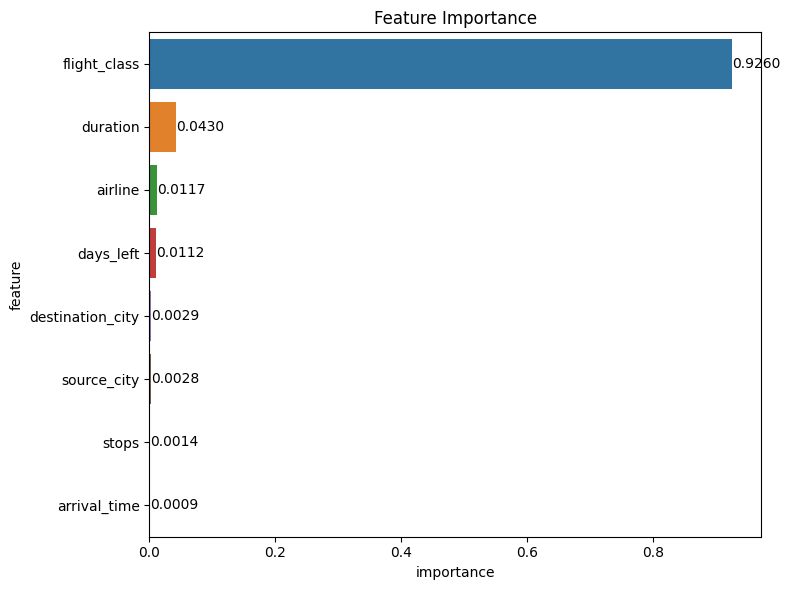

In [62]:
# plot for feature importance
rankings = ml_model.feature_importances_.tolist()
importance = pd.DataFrame(sorted(zip(X_train.columns, rankings),
                            reverse=True), columns=["feature", "importance"]).sort_values("importance",ascending = False)

plt.figure(figsize=(8,6))
sns.barplot(x="importance",
            y="feature",
            data=importance[:8])

# add R2 values above each bar
for i, v in enumerate(importance['importance'][:8]):
    plt.text(v, i, f'{v:.4f}', ha='left', va='center', color='black')

plt.title('Feature Importance')
plt.tight_layout()

# save as image to file
plt.savefig('D:/programming/information-technologies-of-smart-systems/term-paper/models/feature_baseline_importance.png', format='png', dpi=300)

plt.show()

In [63]:
# display baseline model params
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [64]:
# display baseline model params
dtree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [66]:
# display baseline model params
xgbt.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

### Tuned Random Forest Regressor

In [35]:
# split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# check type of y_train
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>


In [37]:
# convert data to Series
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]

In [38]:
# check type of y_train
print(type(y_train))

<class 'pandas.core.series.Series'>


In [39]:
# check type of y_train
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>


In [40]:
# convert data to Series
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.iloc[:, 0]

In [41]:
# check type of y_train
print(type(y_test))

<class 'pandas.core.series.Series'>


In [42]:
# function to format score_train in desired pattern
def format_score(score):
    return "{:.6f}".format(score)

In [43]:
rf = RandomForestRegressor(**params_rf, random_state = 42).fit(X_train, y_train)

Y_train_pred = rf.predict(X_train)

# calculating metrics
score_train = rf.score(X_train, y_train)
mse_train = mean_squared_error(y_train, Y_train_pred)
mae_train = mean_absolute_error(y_train, Y_train_pred)
r2_train = r2_score(y_train, Y_train_pred)

# Displaying metrics in a grid
metrics_df = pd.DataFrame({
    'Metric': ['Score', 'MSE', 'MAE', 'R2'],
    'Train Data': [format_score(score_train), mse_train, mae_train, r2_train]
})

print(metrics_df)

  Metric      Train Data
0  Score        0.994038
1    MSE  3072902.742982
2    MAE      721.651477
3     R2        0.994038


In [44]:
# initialize ShuffleSplit with desired parameters
shuffle_split = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# initialize lists to store evaluation metrics
train_scores = []
test_scores = []
train_mses = []
test_mses = []
train_maes = []
test_maes = []
train_r2s = []
test_r2s = []

for train_index, test_index in shuffle_split.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    rf = RandomForestRegressor(random_state=42).fit(X_train, y_train)

    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)

    # calculating metrics for train and test sets
    train_score = rf.score(X_train, y_train)
    test_score = rf.score(X_test, y_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # append metrics to lists
    train_scores.append(train_score)
    test_scores.append(test_score)
    train_mses.append(train_mse)
    test_mses.append(test_mse)
    train_maes.append(train_mae)
    test_maes.append(test_mae)
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)

# average the metrics over all splits
avg_train_score = np.mean(train_scores)
avg_test_score = np.mean(test_scores)
avg_train_mse = np.mean(train_mses)
avg_test_mse = np.mean(test_mses)
avg_train_mae = np.mean(train_maes)
avg_test_mae = np.mean(test_maes)
avg_train_r2 = np.mean(train_r2s)
avg_test_r2 = np.mean(test_r2s)


# displaying metrics in a grid
metrics_df = pd.DataFrame({
    'Metric': ['Score', 'MSE', 'MAE', 'R2'],
    'Train Data': [format_score(avg_train_score), avg_train_mse, avg_train_mae, avg_train_r2],
    'Test Data': [format_score(avg_test_score), avg_test_mse, avg_test_mae, avg_test_r2]
})

print(metrics_df)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionW

  Metric      Train Data       Test Data
0  Score        0.997511        0.984844
1    MSE  1284849.666489  7816509.613863
2    MAE      441.798409     1143.564963
3     R2        0.997511        0.984844


In [ ]:
# plot for feature importance
rankings = ml_model.feature_importances_.tolist()
importance = pd.DataFrame(sorted(zip(X_train.columns, rankings),
                            reverse=True), columns=["feature", "importance"]).sort_values("importance",ascending = False)

plt.figure(figsize=(8,6))
sns.barplot(x="importance",
            y="feature",
            data=importance[:8])

# add R2 values above each bar
for i, v in enumerate(importance['importance'][:8]):
    plt.text(v, i, f'{v:.4f}', ha='left', va='center', color='black')

plt.title('Feature Importance for Random Forest Tuned Regressor')
plt.tight_layout()

# save as image to file
plt.savefig('D:/programming/information-technologies-of-smart-systems/term-paper/models/feature_rf_tuned_importance.png', format='png', dpi=300)

plt.show()

In [73]:
# define the file path
file_path = 'D:/programming/information-technologies-of-smart-systems/term-paper/models/random-forest-metrics.csv'

# save the DataFrame to a CSV file
metrics_df.to_csv(file_path, index=False)

# print a message confirming the file has been saved
print("Metrics have been saved to:", file_path)

Metrics have been saved to: D:/programming/information-technologies-of-smart-systems/term-paper/models/random-forest-metrics.csv


In [45]:
# filepath for main trained model
rf_final_path = 'D:/programming/information-technologies-of-smart-systems/term-paper/models/finalized_rf_model.sav'

In [46]:
# save main trained Random Forest Regressor model
with open(rf_final_path, 'wb') as file:
    pickle.dump(rf, file)

### Tuned Decision Tree Regressor

In [47]:
# split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# check type of y_train
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>


In [49]:
# convert data to Series
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]

In [50]:
# check type of y_train
print(type(y_train))

<class 'pandas.core.series.Series'>


In [51]:
# check type of y_train
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>


In [52]:
# convert data to Series
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.iloc[:, 0]

In [53]:
# check type of y_train
print(type(y_test))

<class 'pandas.core.series.Series'>


In [54]:
# initialize ShuffleSplit with desired parameters
shuffle_split = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# initialize lists to store evaluation metrics
train_scores = []
test_scores = []
train_mses = []
test_mses = []
train_maes = []
test_maes = []
train_r2s = []
test_r2s = []

for train_index, test_index in shuffle_split.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    dtree = DecisionTreeRegressor(**params_dtree, random_state=42).fit(X_train, y_train)

    y_train_pred = dtree.predict(X_train)
    y_test_pred = dtree.predict(X_test)

    # calculating metrics for train and test sets
    train_score = dtree.score(X_train, y_train)
    test_score = dtree.score(X_test, y_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # append metrics to lists
    train_scores.append(train_score)
    test_scores.append(test_score)
    train_mses.append(train_mse)
    test_mses.append(test_mse)
    train_maes.append(train_mae)
    test_maes.append(test_mae)
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)

# average the metrics over all splits
avg_train_score = np.mean(train_scores)
avg_test_score = np.mean(test_scores)
avg_train_mse = np.mean(train_mses)
avg_test_mse = np.mean(test_mses)
avg_train_mae = np.mean(train_maes)
avg_test_mae = np.mean(test_maes)
avg_train_r2 = np.mean(train_r2s)
avg_test_r2 = np.mean(test_r2s)


# displaying metrics in a grid
metrics_df = pd.DataFrame({
    'Metric': ['Score', 'MSE', 'MAE', 'R2'],
    'Train Data': [format_score(avg_train_score), avg_train_mse, avg_train_mae, avg_train_r2],
    'Test Data': [format_score(avg_test_score), avg_test_mse, avg_test_mae, avg_test_r2]
})

print(metrics_df)

  Metric      Train Data       Test Data
0  Score        0.990959        0.981902
1    MSE  4666416.795227  9333686.400281
2    MAE      862.867537     1269.055701
3     R2        0.990959        0.981902


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


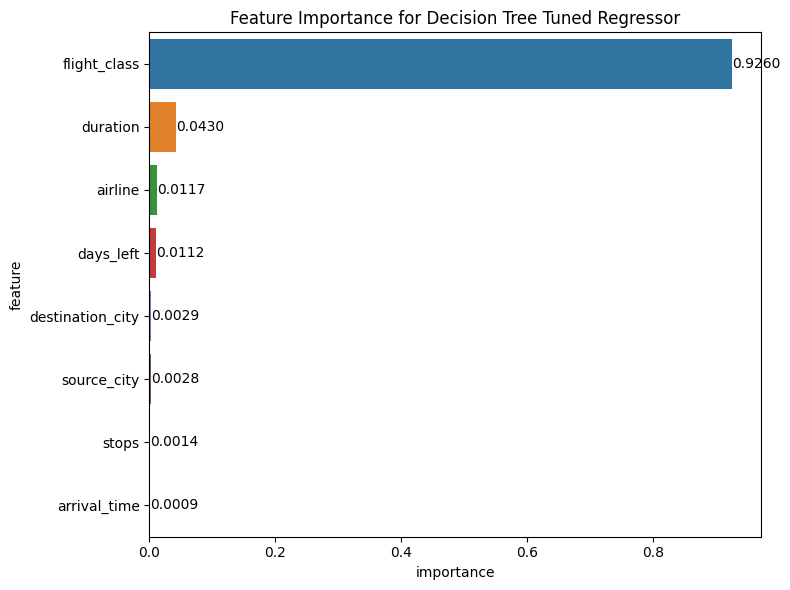

In [86]:
# plot for feature importance
rankings = ml_model.feature_importances_.tolist()
importance = pd.DataFrame(sorted(zip(X_train.columns, rankings),
                            reverse=True), columns=["feature", "importance"]).sort_values("importance",ascending = False)

plt.figure(figsize=(8,6))
sns.barplot(x="importance",
            y="feature",
            data=importance[:8])

# add R2 values above each bar
for i, v in enumerate(importance['importance'][:8]):
    plt.text(v, i, f'{v:.4f}', ha='left', va='center', color='black')

plt.title('Feature Importance for Decision Tree Tuned Regressor')
plt.tight_layout()

# save as image to file
plt.savefig('D:/programming/information-technologies-of-smart-systems/term-paper/models/feature_dtree_tuned_importance.png', format='png', dpi=300)

plt.show()

In [87]:
# define the file path
file_path = 'D:/programming/information-technologies-of-smart-systems/term-paper/models/decision-tree-metrics.csv'

In [88]:
# save the DataFrame to a CSV file
metrics_df.to_csv(file_path, index=False)

In [89]:
# print a message confirming the file has been saved
print("Metrics have been saved to:", file_path)

Metrics have been saved to: D:/programming/information-technologies-of-smart-systems/term-paper/models/decision-tree-metrics.csv


In [55]:
# filepath for main trained model
dtree_final_path = 'D:/programming/information-technologies-of-smart-systems/term-paper/models/finalized_dtree_model.sav'

In [56]:
# save main trained Decision Tree Regressor model
with open(dtree_final_path, 'wb') as file:
    pickle.dump(dtree, file)

### Tuned XGB Regressor

In [57]:
# split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# check type of y_train
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>


In [59]:
# convert data to Series
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]

In [60]:
# check type of y_train
print(type(y_train))

<class 'pandas.core.series.Series'>


In [61]:
# check type of y_train
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>


In [62]:
# convert data to Series
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.iloc[:, 0]

In [63]:
# check type of y_train
print(type(y_test))

<class 'pandas.core.series.Series'>


In [64]:
# initialize ShuffleSplit with desired parameters
shuffle_split = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# initialize lists to store evaluation metrics
train_scores = []
test_scores = []
train_mses = []
test_mses = []
train_maes = []
test_maes = []
train_r2s = []
test_r2s = []

for train_index, test_index in shuffle_split.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    xgbr = xgb.XGBRegressor(**params_xgb, random_state=42).fit(X_train, y_train)

    y_train_pred = xgbr.predict(X_train)
    y_test_pred = xgbr.predict(X_test)

    # calculating metrics for train and test sets
    train_score = xgbr.score(X_train, y_train)
    test_score = xgbr.score(X_test, y_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # append metrics to lists
    train_scores.append(train_score)
    test_scores.append(test_score)
    train_mses.append(train_mse)
    test_mses.append(test_mse)
    train_maes.append(train_mae)
    test_maes.append(test_mae)
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)

# average the metrics over all splits
avg_train_score = np.mean(train_scores)
avg_test_score = np.mean(test_scores)
avg_train_mse = np.mean(train_mses)
avg_test_mse = np.mean(test_mses)
avg_train_mae = np.mean(train_maes)
avg_test_mae = np.mean(test_maes)
avg_train_r2 = np.mean(train_r2s)
avg_test_r2 = np.mean(test_r2s)


# displaying metrics in a grid
metrics_df = pd.DataFrame({
    'Metric': ['Score', 'MSE', 'MAE', 'R2'],
    'Train Data': [format_score(avg_train_score), avg_train_mse, avg_train_mae, avg_train_r2],
    'Test Data': [format_score(avg_test_score), avg_test_mse, avg_test_mae, avg_test_r2]
})

print(metrics_df)

  Metric     Train Data       Test Data
0  Score       0.995870        0.987094
1    MSE  2131408.21267  6656399.631143
2    MAE     753.869774     1269.008571
3     R2        0.99587        0.987094


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


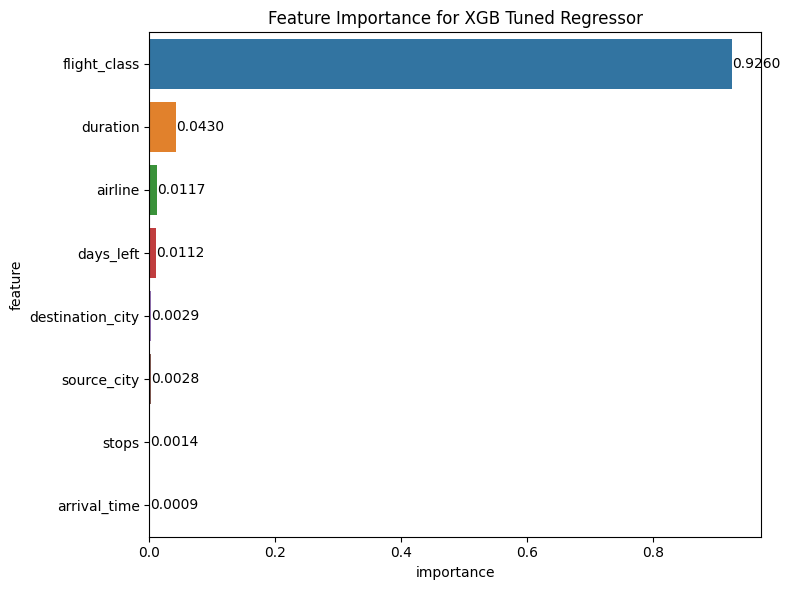

In [101]:
# plot for feature importance
rankings = ml_model.feature_importances_.tolist()
importance = pd.DataFrame(sorted(zip(X_train.columns, rankings),
                            reverse=True), columns=["feature", "importance"]).sort_values("importance",ascending = False)

plt.figure(figsize=(8,6))
sns.barplot(x="importance",
            y="feature",
            data=importance[:8])

# add R2 values above each bar
for i, v in enumerate(importance['importance'][:8]):
    plt.text(v, i, f'{v:.4f}', ha='left', va='center', color='black')

plt.title('Feature Importance for XGB Tuned Regressor')
plt.tight_layout()

# save as image to file
plt.savefig('D:/programming/information-technologies-of-smart-systems/term-paper/models/feature_xgb_tuned_importance.png', format='png', dpi=300)

plt.show()

In [65]:
# define the file path
file_path = 'D:/programming/information-technologies-of-smart-systems/term-paper/models/xgb-metrics.csv'

In [66]:
# save the DataFrame to a CSV file
metrics_df.to_csv(file_path, index=False)

In [67]:
# print a message confirming the file has been saved
print("Metrics have been saved to:", file_path)

Metrics have been saved to: D:/programming/information-technologies-of-smart-systems/term-paper/models/xgb-metrics.csv


In [68]:
# filepath for main trained model
xgb_final_path = 'D:/programming/information-technologies-of-smart-systems/term-paper/models/finalized_xgb_model.sav'

In [69]:
# save main trained Decision Tree Regressor model
with open(xgb_final_path, 'wb') as file:
    pickle.dump(xgbr, file)